# Quickstart Example with Synthetic Bandit Data
---
This notebook provides an example of conducting OPE of several different evaluation policies with synthetic logged bandit data.

The example consists of the follwoing four major steps:
- (1) Generating Synthetic Data
- (2) Off-Policy Learning
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

Please see [../examples/synthetic](../synthetic) for a more sophisticated example of the evaluation of OPE with synthetic bandit data.

In [1]:
# needed when using Google Colab
# !pip install obp

In [1]:
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression

# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_reward_function,
    linear_behavior_policy
)
from obp.policy import IPWLearner, Random
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)

In [2]:
# obp version
print(obp.__version__)

0.5.0


## (1) Generating Synthetic Data
`obp.dataset.SyntheticBanditDataset` is an easy-to-use synthetic data generator.

It takes 
- number of actions (`n_actions`, $|\mathcal{A}|$)
- dimension of context vectors (`dim_context`, $d$)
- reward function (`reward_function`, $q(x,a)=\mathbb{E}[r \mid x,a]$)
- behavior policy (`behavior_policy_function`, $\pi_b(a|x)$) 

as inputs and generates synthetic logged bandit data that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.

In [3]:
# generate synthetic logged bandit data with 10 actions
# we use `logistic function` as the reward function and `linear_behavior_policy` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    tau=1.0, # temperature hyperparameter to control the entropy of the behavior policy
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345,
)

In [4]:
# obtain training and test sets of synthetic logged bandit feedback
n_rounds_train, n_rounds_test = 100000, 100000
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_train)
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_test)

the logged bandit feedback is collected by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}$  where $(x,a,r) \sim p(x)\pi_b(a \mid x)p(r \mid x,a) $

In [5]:
# `bandit_feedback` is a dictionary storing synthetic logged bandit data
bandit_feedback_train

{'n_rounds': 100000,
 'n_actions': 10,
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [ 1.36946256,  0.58727761, -0.69296769, -0.27519988, -2.10289159],
        [-0.27428715,  0.52635353,  1.02572168, -0.18486381,  0.72464834],
        [-1.25579833, -1.42455203, -0.26361242,  0.27928604,  1.21015571]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([9, 2, 1, ..., 9, 1, 5]),
 'position': None,
 'r

## (2) Off-Policy Learning
After generating synthetic data, we now train some candidate evaluation policies using the training bandit dataset. <br>

We use `obp.ope.IPWLearner` to train evaluation policies. 
We also use *RandomForestClassifier* and *LogisticRegression* implemented in scikit-learn for base machine learning methods.

In [6]:
# define IPWLearner with Logistic Regression as its base ML model
ipw_lr = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=LogisticRegression(C=100, random_state=12345)
)

# train IPWLearner on the training set of logged bandit data
ipw_lr.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)

# obtains action choice probabilities for the test set
action_dist_ipw_lr = ipw_lr.predict(context=bandit_feedback_test["context"])

In [7]:
# define IPWLearner with Random Forest as its base ML model
ipw_rf = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=RandomForest(n_estimators=30, min_samples_leaf=10, random_state=12345)
)

# train IPWLearner on the training set of logged bandit data
ipw_rf.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)

# obtains action choice probabilities for the test set
action_dist_ipw_rf = ipw_rf.predict(context=bandit_feedback_test["context"])

In [8]:
# define Uniform Random Policy as a baseline evaluation policy
random = Random(n_actions=dataset.n_actions,)

# obtains action choice probabilities for the test set
action_dist_random = random.compute_batch_action_dist(
    n_rounds=bandit_feedback_test["n_rounds"]
)

In [9]:
# action_dist is a probability distribution over actions (can be deterministic)
action_dist_ipw_lr[:, :, 0]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## (3) Off-Policy Evaluation (OPE)
Our next step is OPE, which attempts to estimate the performance of evaluation policies using the logged bandit feedback and OPE estimators.

Here, we use 
- `obp.ope.InverseProbabilityWeighting` (IPW)
- `obp.ope.DirectMethod` (DM)
- `obp.ope.DoublyRobust` (DR)

as OPE estimators and visualize the OPE results.

### (3-1) Obtaining a reward estimator
A reward estimator $\hat{q}(x,a)$ is needed for model dependent estimators such as DM or DR.

$\hat{q}(x,a) \approx \mathbb{E} [r \mid x,a]$

In [10]:
# estimate the expected reward by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    action_context=dataset.action_context,
    base_model=LogisticRegression(random_state=12345),
)

In [11]:
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback_test["context"],
    action=bandit_feedback_test["action"],
    reward=bandit_feedback_test["reward"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.

### (3-2) Off-Policy Evaluation
$V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_b, \theta)$ using DM, IPW, and DR

In [12]:
# estimate the policy value of the evaluation policies based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_test,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.784805          0.767594          0.803541
dm   0.648009          0.646855          0.649021
dr   0.770691          0.760420          0.778522 



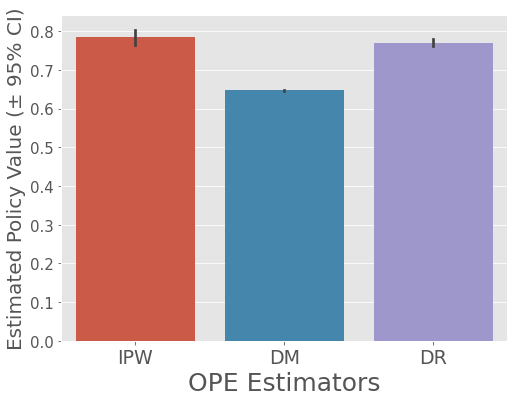

In [13]:
# estimate the policy value of IPWLearner with Logistic Regression
estimated_policy_value_a, estimated_interval_a = ope.summarize_off_policy_estimates(
    action_dist=action_dist_ipw_lr,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_a, '\n')

# visualize policy values of IPWLearner with Logistic Regression estimated by the three OPE estimators
ope.visualize_off_policy_estimates(
    action_dist=action_dist_ipw_lr,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=1000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.707511          0.691352          0.725633
dm   0.627372          0.626142          0.628639
dr   0.703989          0.695135          0.712832 



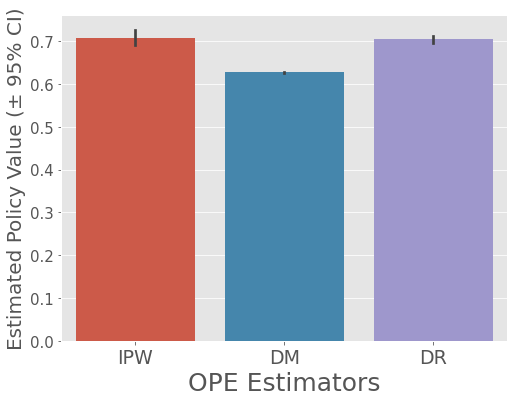

In [14]:
# estimate the policy value of IPWLearner with Random Forest
estimated_policy_value_b, estimated_interval_b = ope.summarize_off_policy_estimates(
    action_dist=action_dist_ipw_rf,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_b, '\n')

# visualize policy values of IPWLearner with Random Forest estimated by the three OPE estimators
ope.visualize_off_policy_estimates(
    action_dist=action_dist_ipw_rf,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=1000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.605677          0.602447          0.608713
dm   0.605383          0.604123          0.606918
dr   0.605225          0.602239          0.608934 



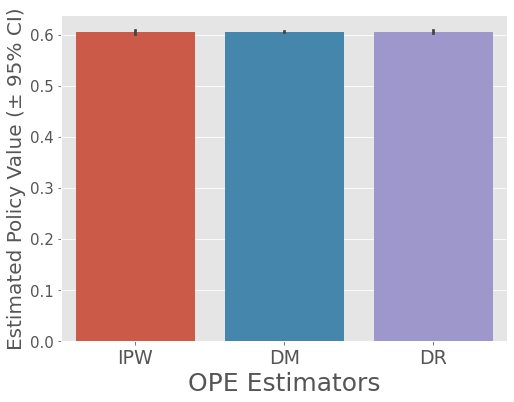

In [15]:
# estimate the policy value of Uniform Random
estimated_policy_value_c, estimated_interval_c = ope.summarize_off_policy_estimates(
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_c, '\n')

# visualize policy values of Uniform Random estimated by the three OPE estimators
ope.visualize_off_policy_estimates(
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=1000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

OPE procedure estimates that IPWLearners largely outperform the Uniform Random policy.

Moreover, IPWLearner with Logistic Regression seems to be the best one.

## (4) Evaluation of OPE estimators
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

### (4-1) Approximate the Ground-truth Policy Value 
With synthetic data, we can calculate the ground-truth policy value of the evaluation policies as follows.

$$V(\pi_e) \approx \frac{1}{|\mathcal{D}_{te}|} \sum_{i=1}^{|\mathcal{D}_{te}|} \mathbb{E}_{a \sim \pi_e(a|x_i)} [q(x_i, a)], \; \, where \; \, q(x,a) := \mathbb{E}_{r \sim p(r|x,a)} [r]$$

In [16]:
# we first calculate the policy values of the three evaluation policies based on the expected rewards of the test data
policy_names = ["IPW Learner with Logistic Regression", "IPWLearner with Random Forest", "Unifrom Random"]
for name, action_dist in zip(policy_names, [action_dist_ipw_lr, action_dist_ipw_rf, action_dist_random]):
    true_policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist,
    )
    print(f'policy value of {name}: {true_policy_value}')

policy value of IPW Learner with Logistic Regression: 0.7745466707388633
policy value of IPWLearner with Random Forest: 0.7083979540442642
policy value of Unifrom Random: 0.6061787431111193


In fact, IPWLearner with Logistic Regression reveals the best performance among the three evaluation policies.

Using the above policy values, we evaluate the estimation accuracy of the OPE estimators.

### (4-2) Evaluation of OPE

We can then evaluate the estimation performance of OPE estimators by comparing the estimated policy values of the evaluation with its ground-truth as follows.

- $\textit{relative-ee} (\hat{V}; \mathcal{D}_b) := \left| \frac{V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b)}{V(\pi_e)} \right|$ (relative estimation error; relative-ee)
- $\textit{SE} (\hat{V}; \mathcal{D}_b) := \left( V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b) \right)^2$ (squared error; se)

In [17]:
# evaluate the estimation performances of OPE estimators for IPWLearner with Logistic Regression
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_for_ipw_lr = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist_ipw_lr,
    ),
    action_dist=action_dist_ipw_lr,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performance of the estimators (lower means accurate)
relative_ee_for_ipw_lr

,relative-ee
ipw,0.013322
dm,0.163305
dr,0.005725


In [18]:
# evaluate the estimation performance of OPE estimators for IPW with Random Forest
relative_ee_for_ipw_rf = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist_ipw_rf,
    ),
    action_dist=action_dist_ipw_rf,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performance of the estimators (lower means accurate)
relative_ee_for_ipw_rf

,relative-ee
ipw,0.000467
dm,0.114327
dr,0.006050


In [19]:
# evaluate the estimation performance of OPE estimators for Uniform Random
relative_ee_for_random = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist_random,
    ),
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performance of the estimators (lower means accurate)
relative_ee_for_random

,relative-ee
ipw,0.001566
dm,0.001440
dr,0.001492


We can iterate the above process several times to get more relibale results.

Please see [../examples/synthetic](../synthetic) for a more sophisticated example of the evaluation of OPE with synthetic bandit data.